# Setup

In [37]:
import wandb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Normalise
X_train, X_test = X_train/255.0, X_test/255.0

# Model

In [5]:
# Configure the wandb sweep
sweep_config = {
    'method': 'random',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1, 0.1, 0.01, 0.001, 0.0001]
        },
        'epochs': {
            'values': [10, 20, 50, 100, 150, 200]
        },
        'batch_size': {
            'values': [16, 32, 64, 128, 256]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'layers': {
            'values': [1, 2, 3, 4, 5]
        },
        'dropout': {
            'values': [0.3, 0.2, 0.1]
        },
    }
}

In [6]:
# Initialise sweep
sweep_id = wandb.sweep(sweep_config, project='tensorflow-test', entity='kavp')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: wmtw5ten
Sweep URL: https://wandb.ai/kavp/tensorflow-test/sweeps/wmtw5ten


In [7]:
# Mega function to define and train model and log results (used by the sweep)
def sweep_func():
    # Default hyperparameter values
    config_defaults = {
        'learning_rate': 0.001,
        'epochs': 100,
        'batch_size': 128,
        'optimizer': 'adam',
        'layers': 1,
        'dropout': 0.2,
        'eager_mode': False,
    }

    # Initialise run
    wandb.init(config=config_defaults)

    # Variable to hold the sweep values
    config = wandb.config
    
    if config['eager_mode'] == True:
        tf.compat.v1.enable_eager_execution()
    elif config['eager_mode'] == False:
        tf.compat.v1.disable_eager_execution()
    else:
        raise ValueError('eager_mode property of wandb config could not be determined.') 

    # Define empty model
    model = tf.keras.models.Sequential()

    # Flatten
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    # Fill model with dense layers based on layers parameter
    for i in range(config['layers']):
        model.add(tf.keras.layers.Dense(round(128/(i+1)), activation='relu'))
        model.add(tf.keras.layers.Dropout(config['dropout']))

    # Add softmax for classification
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=config['optimizer'],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=config['eager_mode'],
    )

    with tf.compat.v1.Session() as sess:
        r = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=config['epochs'], batch_size=config['batch_size'])
        wandb.tensorflow.log(tf.compat.v1.summary.merge_all())
        wandb.log({'loss': r.history['loss'][-1], 'val_loss': r.history['val_loss'][-1], 'accuracy': r.history['accuracy'][-1], 'val_accuracy': r.history['val_accuracy'][-1]})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['loss'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "loss"])
        wandb.log({"loss_against_epochs" : wandb.plot.line(table, "epoch", "loss", title="Training loss")})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['val_loss'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "val_loss"])
        wandb.log({"val_loss_against_epochs" : wandb.plot.line(table, "epoch", "val_loss", title="Validation loss")})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['accuracy'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "accuracy"])
        wandb.log({"accuracy_against_epochs" : wandb.plot.line(table, "epoch", "accuracy", title="Training accuracy")})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['val_accuracy'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "val_accuracy"])
        wandb.log({"val_accuracy_against_epochs" : wandb.plot.line(table, "epoch", "val_accuracy", title="Validation accuracy")})

        # Save model
        model.save(os.path.join(wandb.run.dir, 'model.h5'))

In [ ]:
wandb.agent(sweep_id, sweep_func)

In [9]:
wandb.finish()

# Predictions

In [16]:
# Load a good run
good_run_path = 'kavp/tensorflow-test/fe5o3h0z/'
run = wandb.Api().run(good_run_path)
# Load model
best_model = wandb.restore('model.h5', run_path=good_run_path)
# Load config
config = run.config

# New model
model = tf.keras.models.Sequential()

# Flatten
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

# Fill model with dense layers based on layers parameter
for i in range(config['layers']):
    model.add(tf.keras.layers.Dense(round(128/(i+1)), activation='relu'))
    model.add(tf.keras.layers.Dropout(config['dropout']))

# Add softmax for classification
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(
    optimizer=config['optimizer'],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=config['eager_mode'],
)

# Load its weights into the new model
model.load_weights(best_model.name)

In [36]:
# Obtain some predictions and plot the confusion matrix
# argmax to get predictions from one-hot encoded vectors
predicted_class = tf.argmax(model.predict(X_test),1)
tf.math.confusion_matrix(y_test, predicted_class)

313/313 [==============================] - 0s 927us/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 971,    0,    1,    0,    1,    0,    3,    1,    3,    0],
       [   0, 1121,    3,    1,    0,    1,    4,    2,    2,    1],
       [   2,    0, 1019,    2,    2,    0,    2,    3,    2,    0],
       [   0,    0,    8,  986,    0,    6,    0,    4,    1,    5],
       [   0,    0,    1,    0,  957,    0,    7,    3,    0,   14],
       [   2,    0,    0,    7,    0,  869,    6,    1,    4,    3],
       [   4,    2,    0,    1,    6,    2,  942,    0,    1,    0],
       [   1,    1,    9,    2,    1,    0,    0, 1010,    0,    4],
       [   7,    1,    8,    6,    3,    5,    4,    3,  932,    5],
       [   1,    3,    0,    6,    6,    1,    1,    8,    1,  982]])>

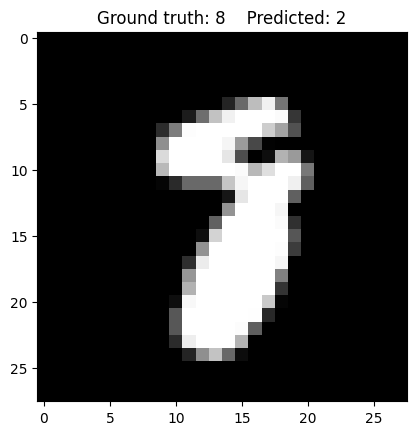

In [83]:
# Show some misclassified examples
misclassified = np.where(predicted_class != y_test)[0]
index = np.random.choice(misclassified)
plt.imshow(X_test[index], cmap='gray')
plt.title('Ground truth: %s    Predicted: %s' % (y_test[index], tf.get_static_value(predicted_class[index])));